#  Прогнозирование количества заказов для сервиса такси

# Описание проекта

Заказчик - компания такси - собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# План проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

# Описание данных
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

Загрузил данные и выполнил их ресемплирование по одному часу.

In [64]:
!pip install --upgrade scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose

# Предобработка данных
from sklearn.model_selection import train_test_split

# Модели обучение
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit 


RANDOM_STATE = 3

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Просортирую, тк данные могут поменяться
data.sort_index(inplace=True)

print('Дата монатонна =', data.index.is_monotonic)
data.info()

Дата монатонна = True
,<class 'pandas.core.frame.DataFrame'>
,DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
,Data columns (total 1 columns):
, #   Column      Non-Null Count  Dtype
,---  ------      --------------  -----
, 0   num_orders  26496 non-null  int64
,dtypes: int64(1)
,memory usage: 414.0 KB


In [4]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод** Загрузил данные, пропарсил дату и установил их как индекс. Просортировал данные и проверил, что дата монатонно увеличивается. Провёл ресемплирование в диапазон 1 час, просумировав количество заказов. 

## Анализ
### Часовое ресемплирование
Проанализируйем данные.

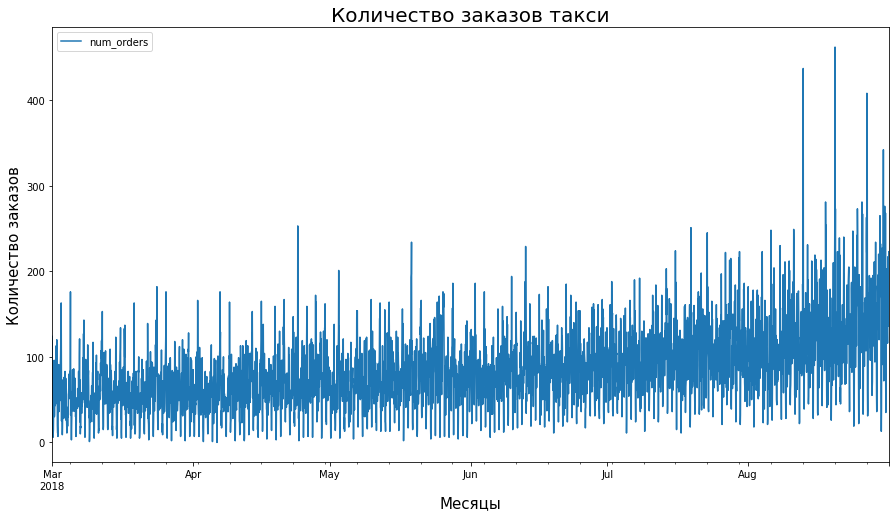

In [5]:
data.plot(figsize=(15, 8))
plt.title('Количество заказов такси', fontsize=20)
plt.xlabel('Месяцы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

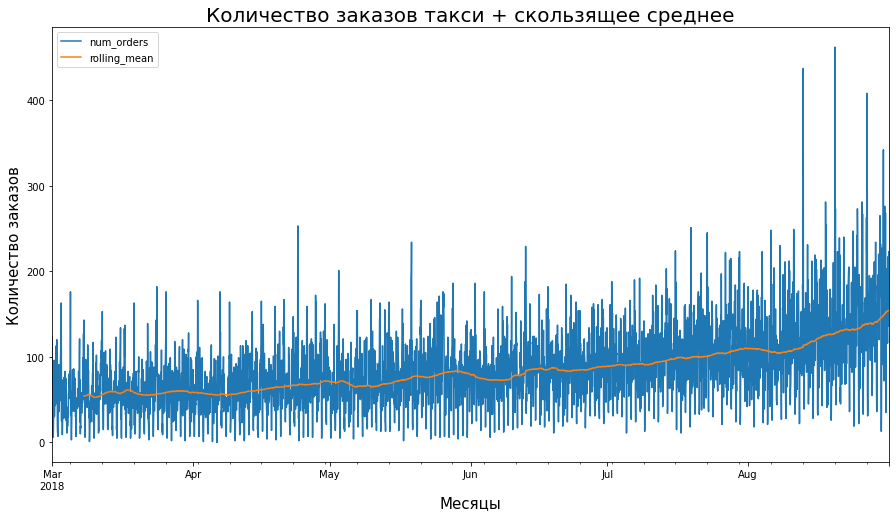

In [7]:
# Сначала построим графики как по заданию в диапазонии в 1 час для всех данных, а после за пару дней
# Скользящее среднее с окном в неделю
data['rolling_mean'] = data.shift().rolling(24*7).mean()

data.plot(figsize=(15, 8))
plt.title('Количество заказов такси + скользящее среднее', fontsize=20)
plt.xlabel('Месяцы', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

**Промежуточный вывод** Благодаря скользящему срендему, видно более сглаженное значение заказов такси, который сильнее всего увеличивается во вторую половину лета

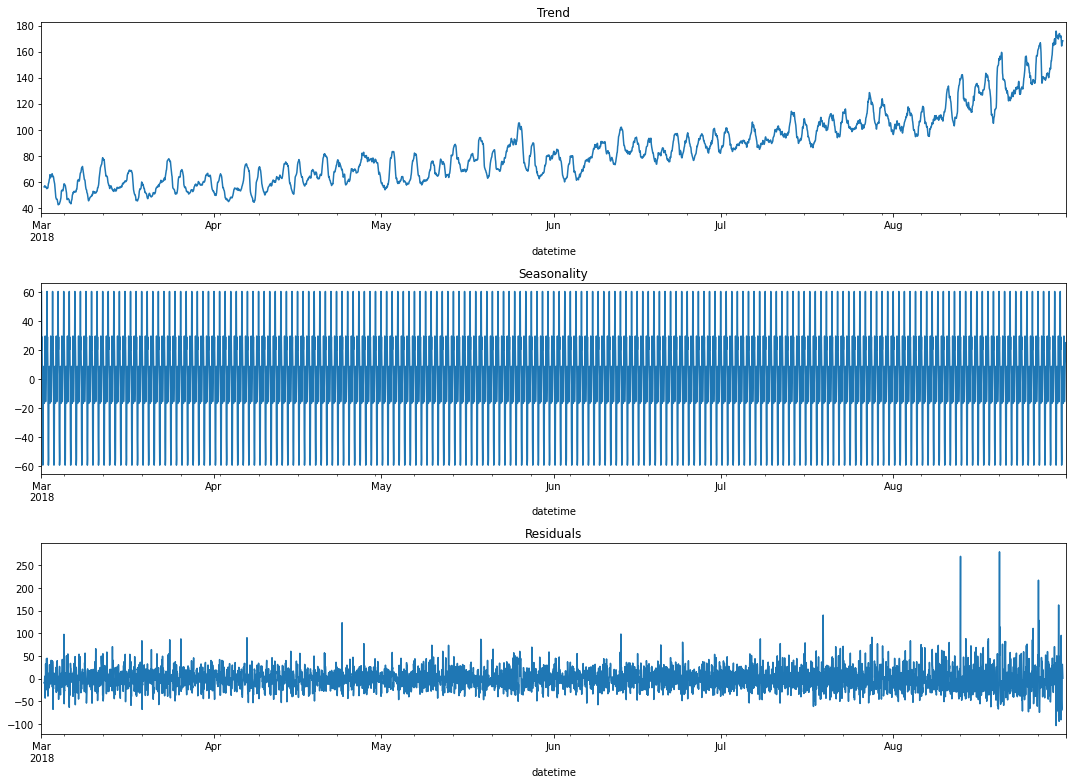

In [8]:
data = data.drop(['rolling_mean'], axis = 1)
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 11))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Промежуточный вывод** Заметно, что тренд связан с временами года, количество заказов такси выше всего во вторую половину лета, и ниже в весеннее. Сезонность связана с периодом меньшей размерности, исследуем её дальше

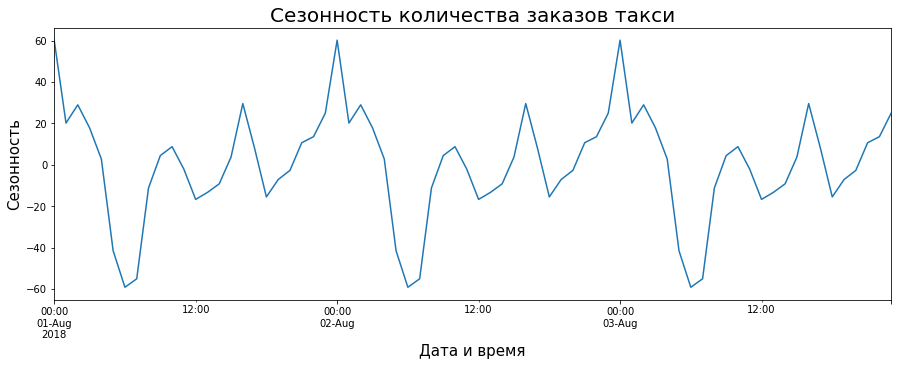

In [9]:
decomposed.seasonal['2018-08-01':'2018-08-3'].plot(figsize=(15, 5))
plt.title('Сезонность количества заказов такси', fontsize=20)
plt.xlabel('Дата и время', fontsize=15)
plt.ylabel('Сезонность', fontsize=15)
plt.show()

**Вывод** В результате анализа данных был замечен тренд связанный с временем года, выше заказов такси во вторую половину лета, также заметна сезонность, где пик заказов приходиться на время ближе к полуночи, а спад заказов наблюдается в 6 часов утра.

 ### Дневное ресемплирование

In [50]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1D').sum()
df.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


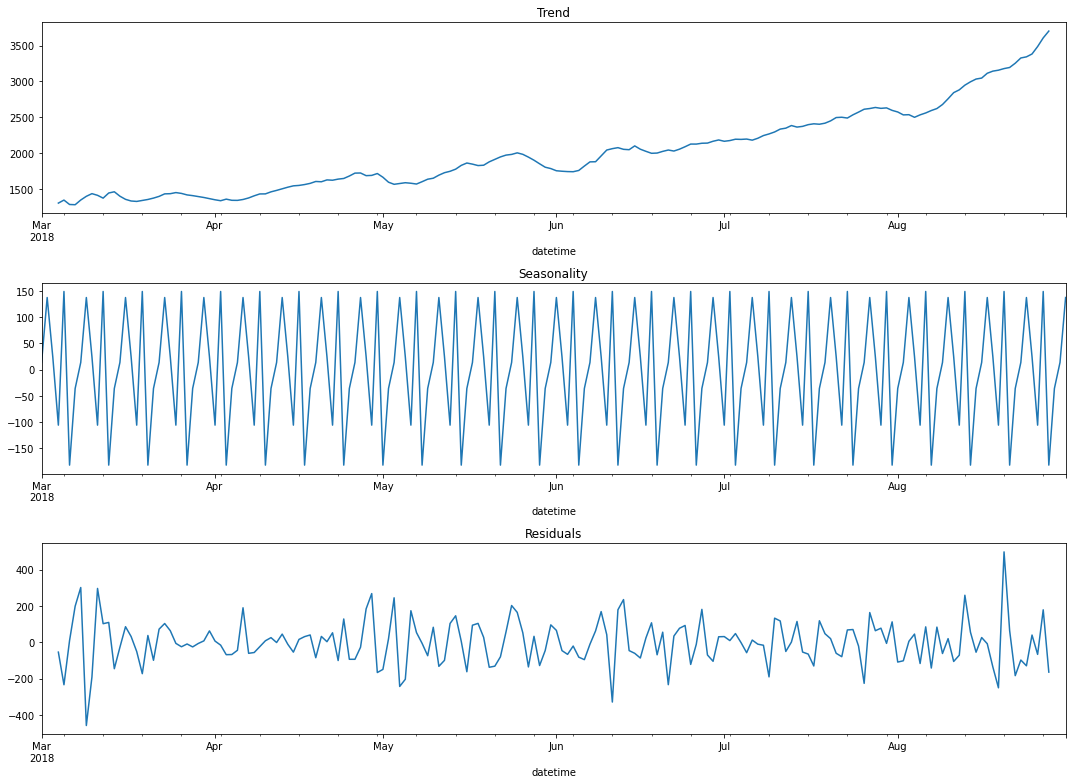

In [51]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 11))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

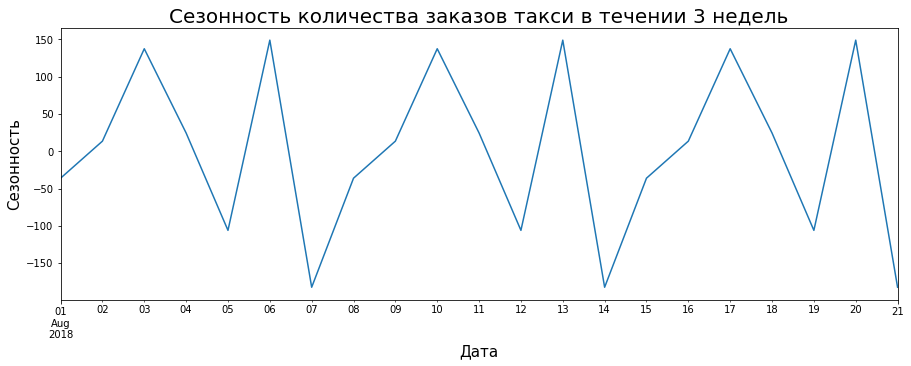

datetime,2018-08-01,2018-08-02,2018-08-03,2018-08-04,2018-08-05,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,...,2018-08-12,2018-08-13,2018-08-14,2018-08-15,2018-08-16,2018-08-17,2018-08-18,2018-08-19,2018-08-20,2018-08-21
num_orders,2429,2445,2679,2569,2311,2794,2270,2669,2630,2916,...,2706,3356,2868,2943,3087,3244,3033,2801,3826,3077
day_of_week,2,3,4,5,6,0,1,2,3,4,...,6,0,1,2,3,4,5,6,0,1


In [59]:
decomposed.seasonal['2018-08-01':'2018-08-21'].plot(figsize=(15, 5))
plt.title('Сезонность количества заказов такси в течении 3 недель', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Сезонность', fontsize=15)
plt.show()
df['day_of_week'] = df.index.dayofweek
df['2018-08-01':'2018-08-21'].T

**Вывод:** Анализ данных семплированных в 1 день показал, что начиная с июля тренд заказов такси повышается всё оставшееся время, что вероятнее связанно с более жаркой температурой и началом осенних дождей. При наблюдении сезонности в несколько недель видно, что зачастую большим спросом пользуется такси в пятницу и понедельник, а во вторник спрос самый низкий

## Обучение

Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [63]:
# Подготовим признаки

def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 48, 60)

train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

X_train = train.drop('num_orders', 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', 1)
y_test = test['num_orders']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3472, 51)
,(884, 51)
,(3472,)
,(884,)


### LinearRegression

In [68]:
model_lr = LinearRegression()

In [69]:
# Время обучения

start = time()

model_lr.fit(X_train, y_train)

end = time()

fit_time_lr = round(end - start, 2)
print(fit_time_lr, 'sec')

0.01 sec


In [70]:
# Время предсказания

tss_for_cv = TimeSeriesSplit(n_splits=2).split(X_train)

start = time()
rmse_lr = cross_val_score(model_lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tss_for_cv)
end = time()

rmse_lr = round(abs(rmse_lr).mean(), 2)
print('rmse =', rmse_lr)

pred_time_lr = round(end - start, 2)
print(pred_time_lr, 'sec')

rmse = 25.04
,0.3 sec


### LightGBM

In [78]:
tss_for_cv = TimeSeriesSplit(n_splits=2).split(X_train)
lgbm_r = LGBMRegressor(random_state=RANDOM_STATE)

parameters = {
    "max_depth": [40, 80],
    "learning_rate" : [0.1, 0.15],
    "n_estimators": [80, 150]
}

gs_lgbm_r = GridSearchCV(
    lgbm_r,
    parameters,
    cv=tss_for_cv,
    scoring='neg_root_mean_squared_error'
)

# Возьмём лучшие парраметры и время сколько уходит на подбор

start = time()

gs_lgbm_r.fit(X_train, y_train)

end = time()

bst_prm_lgbm = round(end - start, 2)
print(bst_prm_lgbm, 'sec')

42.19 sec


In [79]:
lgbm_r_params = gs_lgbm_r.best_params_
lgbm_r_params

# с гиперпараметрами
lgbm_r = LGBMRegressor(max_depth = lgbm_r_params['max_depth'],
                             learning_rate = lgbm_r_params['learning_rate'],
                             n_estimators = lgbm_r_params['n_estimators'], 
                             random_state = RANDOM_STATE)

# Время обучения

start = time()

lgbm_r.fit(X_train, y_train)

end = time()

fit_time_lgbm_r = round(end - start, 2)
print(fit_time_lgbm_r, 'sec')

2.0 sec


In [80]:
# Время предсказания

tss_for_cv = TimeSeriesSplit(n_splits=2).split(X_train)

start = time()
rmse_lgbm_r = cross_val_score(lgbm_r, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tss_for_cv)
end = time()

rmse_lgbm_r = round(abs(rmse_lgbm_r).mean(), 2)
print('rmse =', rmse_lgbm_r)

pred_time_lgbm_r = round(end - start, 2)
print(pred_time_lgbm_r, 'sec')

rmse = 25.01
,3.87 sec


### CatBoost

In [81]:
tss_for_cv = TimeSeriesSplit(n_splits=2).split(X_train)

cb_r = CatBoostRegressor(random_state=RANDOM_STATE)

parameters = {
    "max_depth": [4, 8],
    "learning_rate" : [0.1, 0.15],
    "n_estimators": [80, 150]
}

gs_cb_r = GridSearchCV(
    cb_r,
    parameters,
    cv=tss_for_cv,
    scoring='neg_root_mean_squared_error'
)

# Возьмём лучшие парраметры и время сколько уходит на подбор

start = time()

gs_cb_r.fit(X_train, y_train)

end = time()

bst_prm_cb_r = round(end - start, 2)
print(bst_prm_cb_r, 'sec')

0:	learn: 28.2292746	total: 50.3ms	remaining: 3.97s
,1:	learn: 27.2105231	total: 53.3ms	remaining: 2.08s
,2:	learn: 26.2691680	total: 56.1ms	remaining: 1.44s
,3:	learn: 25.3863626	total: 58.8ms	remaining: 1.12s
,4:	learn: 24.5475334	total: 61.5ms	remaining: 923ms
,5:	learn: 23.8537774	total: 64.3ms	remaining: 793ms
,6:	learn: 23.2594289	total: 66.9ms	remaining: 697ms
,7:	learn: 22.6740770	total: 69.7ms	remaining: 627ms
,8:	learn: 22.2159866	total: 72.3ms	remaining: 570ms
,9:	learn: 21.7105768	total: 75.1ms	remaining: 526ms
,10:	learn: 21.3279229	total: 77.8ms	remaining: 488ms
,11:	learn: 20.9954815	total: 80.6ms	remaining: 457ms
,12:	learn: 20.6654398	total: 83.4ms	remaining: 430ms
,13:	learn: 20.3616754	total: 86ms	remaining: 406ms
,14:	learn: 20.1201049	total: 88.8ms	remaining: 385ms
,15:	learn: 19.9214103	total: 91.5ms	remaining: 366ms
,16:	learn: 19.7092864	total: 94.1ms	remaining: 349ms
,17:	learn: 19.5152885	total: 96.8ms	remaining: 333ms
,18:	learn: 19.3388183	total: 99.5ms	rema

In [82]:
gs_cb_r_params = gs_cb_r.best_params_

# с гиперпараметрами
cb_r = CatBoostRegressor(max_depth = gs_cb_r_params['max_depth'],
                             learning_rate = gs_cb_r_params['learning_rate'],
                             n_estimators = gs_cb_r_params['n_estimators'], 
                             random_state = RANDOM_STATE)

# Время обучения

start = time()

cb_r.fit(X_train, y_train)

end = time()

fit_time_cb_r = round(end - start, 2)
print(fit_time_cb_r, 'sec')

0:	learn: 33.2256693	total: 50.8ms	remaining: 7.57s
,1:	learn: 30.9616935	total: 99.3ms	remaining: 7.35s
,2:	learn: 29.2519385	total: 137ms	remaining: 6.69s
,3:	learn: 27.8114408	total: 165ms	remaining: 6.03s
,4:	learn: 26.6695934	total: 195ms	remaining: 5.65s
,5:	learn: 25.6902670	total: 226ms	remaining: 5.42s
,6:	learn: 24.8080138	total: 256ms	remaining: 5.24s
,7:	learn: 24.1063669	total: 285ms	remaining: 5.06s
,8:	learn: 23.4697966	total: 314ms	remaining: 4.92s
,9:	learn: 22.9223564	total: 351ms	remaining: 4.92s
,10:	learn: 22.4900430	total: 388ms	remaining: 4.91s
,11:	learn: 22.1319989	total: 427ms	remaining: 4.91s
,12:	learn: 21.8489101	total: 457ms	remaining: 4.82s
,13:	learn: 21.5355507	total: 487ms	remaining: 4.73s
,14:	learn: 21.1889285	total: 518ms	remaining: 4.66s
,15:	learn: 20.8609356	total: 550ms	remaining: 4.61s
,16:	learn: 20.5957367	total: 579ms	remaining: 4.53s
,17:	learn: 20.3815359	total: 608ms	remaining: 4.46s
,18:	learn: 20.1760623	total: 638ms	remaining: 4.4s
,19

In [83]:
# Время предсказания

tss_for_cv = TimeSeriesSplit(n_splits=2).split(X_train)

start = time()
rmse_cb_r = cross_val_score(cb_r, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tss_for_cv)
end = time()

rmse_cb_r = round(abs(rmse_cb_r).mean(), 2)
print('rmse =', rmse_cb_r)

pred_time_cb_r = round(end - start, 2)
print(pred_time_cb_r, 'sec')

0:	learn: 27.6760562	total: 36.1ms	remaining: 5.37s
,1:	learn: 26.0272489	total: 57.8ms	remaining: 4.28s
,2:	learn: 24.6006359	total: 79.4ms	remaining: 3.89s
,3:	learn: 23.2007970	total: 101ms	remaining: 3.69s
,4:	learn: 22.0248491	total: 121ms	remaining: 3.51s
,5:	learn: 21.1546950	total: 143ms	remaining: 3.43s
,6:	learn: 20.4089820	total: 168ms	remaining: 3.42s
,7:	learn: 19.7088630	total: 188ms	remaining: 3.33s
,8:	learn: 19.0742178	total: 209ms	remaining: 3.27s
,9:	learn: 18.5420171	total: 229ms	remaining: 3.2s
,10:	learn: 18.0630563	total: 250ms	remaining: 3.15s
,11:	learn: 17.5572050	total: 271ms	remaining: 3.12s
,12:	learn: 17.2064017	total: 293ms	remaining: 3.09s
,13:	learn: 16.8251045	total: 315ms	remaining: 3.06s
,14:	learn: 16.4077099	total: 335ms	remaining: 3.01s
,15:	learn: 16.1079430	total: 355ms	remaining: 2.97s
,16:	learn: 15.7619887	total: 376ms	remaining: 2.94s
,17:	learn: 15.4595673	total: 398ms	remaining: 2.92s
,18:	learn: 15.1844673	total: 420ms	remaining: 2.89s
,1

In [95]:
columns = ['Модель', 'Время обучения, сек', 'Время предсказания, сек', 'RMSE']
regression_model = ['LinearRegression', fit_time_lr, pred_time_lr, rmse_lr]
LightGBM_model = ['LightGBM', fit_time_lgbm_r, pred_time_lgbm_r, rmse_lgbm_r]
CatBoost_model = ['CatBoost', fit_time_cb_r, pred_time_cb_r, rmse_cb_r]

table = pd.DataFrame([regression_model, LightGBM_model, CatBoost_model], columns = columns)

table

,Модель,"Время обучения, сек","Время предсказания, сек",RMSE
0,LinearRegression,0.01,0.30,25.04
1,LightGBM,2.00,3.87,25.01
2,CatBoost,5.17,8.43,25.21


**Вывод** Построил таблицу для анализа точности и быстроты моделей. Наибольную точность получила модель LightGBM = 25.01

## Тестирование
Проверьте данные на тестовой выборке и сделайте выводы.

В качестве эталонной модели будет выступать LightGBM

In [99]:
best_predictions = lgbm_r.predict(X_test)
best_lgbm_r = round(root_mean_squared_error(y_test, best_predictions), 2)
print(f'RMSE LightGBM = {best_lgbm_r}')

table['test RMSE'] = [None, best_lgbm_r, None]
table['Выполнена цель заказчика'] = table['test RMSE'] < 48
table

RMSE LightGBM = 41.71


,Модель,"Время обучения, сек","Время предсказания, сек",RMSE,test RMSE,Выполнена цель заказчика
0,LinearRegression,0.01,0.30,25.04,NaN,False
1,LightGBM,2.00,3.87,25.01,41.71,True
2,CatBoost,5.17,8.43,25.21,NaN,False


## Заключение
В результате исследовательского анализа данных было замеченно:
* присутствует тренд связанный с временем года, большее число заказов такси приходится на во вторую половину лета;
* заметна определённая сезонность, где пик заказов приходиться на время ближе к полуночи, а спад заказов наблюдается в 6 часов утра.
* при наблюдении сезонности в несколько недель видно, что зачастую большим спросом пользуется такси в пятницу и понедельник, а во вторник спрос самый низкий

Для обучения использовалось три модели: `LinearRegression`, `LightGBM`, `CatBoost`.
* Наибольшую точность на валидационных данных показала модель `LightGBM`, метрика RMSE=25.01
* На тестовых данных модель `LightGBM` получила метрику RMSE=41.71, что удовлетворяет условию заказчика (RMSE<48)